# Task 1 - Linear regression with scikit-learn
## Subtasks
Load the datasets from the previous lab. This time you are going to perform the linear regression using
the library scikit-learn.
- Obtain the regression coefficients.
- Once again predict for the following values (35, 80)
- Finally, obtain the MSE value
- Compare the results with the ones obtained in the previous lab.
- Are there any differences?

In [503]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings

In [504]:
income_data = pd.read_csv('datasets/income_data.csv', encoding='unicode_escape')
income_data.head()

,region,age,2020
0,01 Stockholm county,16 years,4.6
1,01 Stockholm county,17 years,8.8
2,01 Stockholm county,18 years,17.8
3,01 Stockholm county,19 years,52.5
4,01 Stockholm county,20 years,112.0


In [505]:
linear_regressor = LinearRegression()
mean_income_by_region_per_age_group = income_data.groupby('age')[
    ['region', '2020']
].mean(numeric_only=True).reset_index()
ages = mean_income_by_region_per_age_group.age
ages_numeric = pd.to_numeric(ages.str.strip('+ years'))
mean_incomes_2020 = mean_income_by_region_per_age_group['2020']

linear_regressor.fit(ages_numeric.to_frame(), mean_incomes_2020)

LinearRegression()

The regression coefficients:

In [506]:
print(linear_regressor.coef_)
linear_regressor.intercept_

[-0.40557442]


301.9047166773686

The first value above is the slope, while the second one is where the regression line intercepts the y-axis.

Now let's predict the income for ages 35 and 80.

In [507]:
ages_to_predict = pd.DataFrame(np.array([35, 80]).reshape(-1, 1), columns=['age'])
linear_regressor.predict(ages_to_predict)

array([287.70961212, 269.45876341])

Now let's check the mean squared error:

In [508]:
predicted_mean_incomes_2020 = linear_regressor.predict(ages_numeric.to_frame())
mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)

9974.38982192875

The results are the same as the ones calculated in lab 2. (Those results were already validated against the scikit-learn linear regression results.)
Finally, let's plot the results:

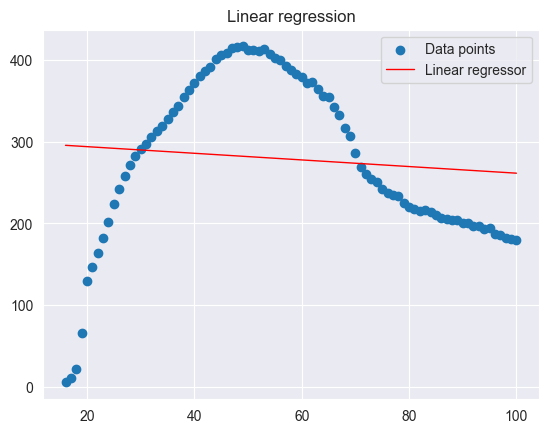

In [509]:
plt.figure()
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
ages_sequence = np.linspace(
    ages_numeric.to_frame().min(), ages_numeric.to_frame().max(), 300
)
ages_sequence_df = pd.DataFrame(ages_sequence, columns=['age'])
plt.plot(
    ages_sequence,
    linear_regressor.predict(ages_sequence_df),
    color='red',
    linewidth=1,
)
plt.title('Linear regression')
plt.legend(['Data points', 'Linear regressor'])
plt.show()

# Task 2 - Polynomial regression with hyperparameter optimization
Linear regression result may not be the optimal result as shown by the MSE value.
We will now use Scikit-learn to perform polynomial regression and evaluate if it is a better model.

## Performing polynomial regression
Polynomial regression is a special case of linear regression.
With the use of `PolynomialFeatures` from `sklearn.preprocessing` you will be able to increase the
number of features the linear regression model is trained.
For additional information on how to perform this task check lecture 8 and page 128 of
the ML book.
Since the data seems to show an inflexion point around age 70, let's start with a 3rd-degree polynomial.

In [510]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


def make_polynomial_regression_pipeline(degree=None):
    if degree is not None:
        return make_pipeline(PolynomialFeatures(degree), LinearRegression())
    else:  # use the default degree for polynomial regression
        return make_pipeline(PolynomialFeatures(), LinearRegression())

degree = 3
polynomial_regression = make_polynomial_regression_pipeline(degree=degree)
polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

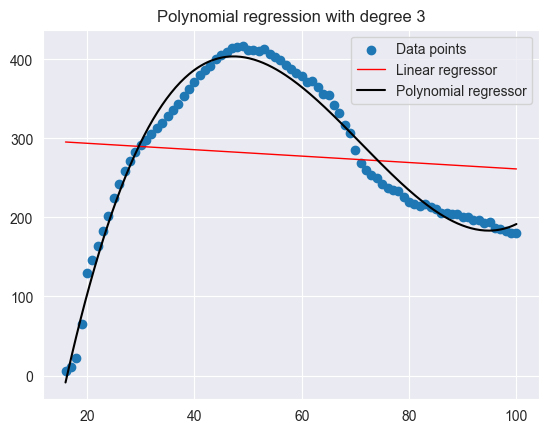

In [511]:
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
plt.plot(
    ages_sequence,
    linear_regressor.predict(ages_sequence_df),
    color='red',
    linewidth=1,
)
plt.plot(
    ages_sequence,
    polynomial_regression.predict(ages_sequence_df),
    color='black',
)
plt.title(f'Polynomial regression with degree {degree}')
plt.legend(['Data points', 'Linear regressor', 'Polynomial regressor'])
plt.show()

We can already see that the polynomial regression fits our data better, but let's check the MSE score regardless.

In [512]:
predicted_mean_incomes_2020 = polynomial_regression.predict(ages_numeric.to_frame())
mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)

210.57459967927306

As we expected, the mean squared error is much less by about two magnitudes!
Now let's find out which hyperparameter works best for the regressor.
## Hyperparameter optimization
You may notice there is a Hyperparameter for this model, which is the polynomial degree,
you will not need to find the optimal degree of this polynomial using Gridsearch.
For this task we will  implement Gridsearch from scratch, we will manually iterate over a set of degrees and find the cross-validation score for each degree to find the optimal degree value.
- Which order of the polynomial is best?

In [513]:
def mse_cost_function_for_polynomial_regression(degree):
    polynomial_regression = make_polynomial_regression_pipeline(degree=degree)
    polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)
    predicted_mean_incomes_2020 = polynomial_regression.predict(
        ages_numeric.to_frame()
    )
    mse = mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)
    return mse

Now we can implement the grid search to find the polynomial degree (our hyperparameter) that results in the fit with the lowest MSE.

In [514]:
import itertools


def simple_grid_search(cost_function, hyperparameter_ranges):
    hyperparameter_names = hyperparameter_ranges.keys()
    hyperparameter_ranges_array = hyperparameter_ranges.values()

    all_steps = [
        {
            param_name:param_value for param_name, param_value
            in zip(hyperparameter_names, grid_point)
        }
        for grid_point in itertools.product(*hyperparameter_ranges_array)
    ]
    grid_results = [cost_function(**step) for step in all_steps]
    best_index = np.argmin(grid_results)
    return all_steps[best_index], grid_results[best_index]


Now we can run the grid search to find the most optimal fit.

In [515]:
DEGREES_TO_SEARCH = np.arange(1, 16)
best_parameters, best_mse = simple_grid_search(
    mse_cost_function_for_polynomial_regression, {'degree': DEGREES_TO_SEARCH}
)
best_degree = best_parameters['degree']
print(f"The lowest MSE ({best_mse:.2f}) was found for degree = {best_degree}")


The lowest MSE (53.36) was found for degree = 8


## Plotting
Graph the results of the polynomial regression line with the optimal degree found along
with the linear regression line.
First encapsulate what we already calculated (the mean squared error) as a cost function
We can see that the lowest MSE was found for an 8th-degree polynomial, let's plot the results as well:

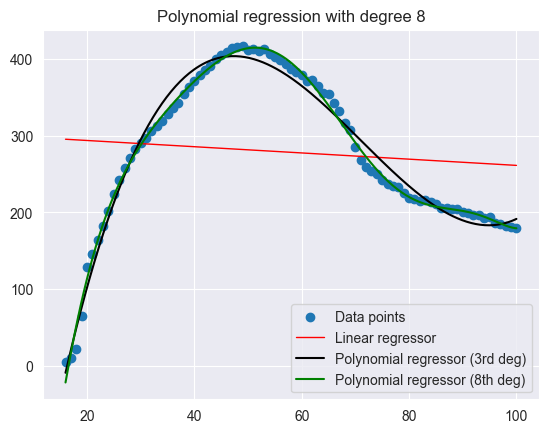

In [516]:
new_polynomial_regression = make_polynomial_regression_pipeline(
    degree=best_degree
)
new_polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)
plt.figure()
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
plt.plot(
    ages_sequence,
    linear_regressor.predict(ages_sequence_df),
    color='red',
    linewidth=1,
)
plt.plot(
    ages_sequence,
    polynomial_regression.predict(ages_sequence_df),
    color='black',
)
plt.plot(
    ages_sequence,
    new_polynomial_regression.predict(ages_sequence_df),
    color='green',
)
plt.title(f'Polynomial regression with degree {best_degree}')
plt.legend([
    'Data points',
    'Linear regressor',
    'Polynomial regressor (3rd deg)',
    'Polynomial regressor (8th deg)',
])
plt.show()

Indeed, the 8th-degree polynomial is a near-perfect fit on the (training) data, but for good measure run `scikit-learn`'s grid search to confirm that that is the case.

In [517]:
from sklearn.model_selection import GridSearchCV


pr_pipeline = make_polynomial_regression_pipeline()
parameter_grid = {
    'polynomialfeatures__degree': DEGREES_TO_SEARCH,
}
grid_search = GridSearchCV(
    pr_pipeline, parameter_grid, scoring='neg_mean_squared_error'
)
grid_search.fit(ages_numeric.to_frame(), mean_incomes_2020)
print(-grid_search.best_score_)
grid_search.best_params_

2606.5382632846627


{'polynomialfeatures__degree': 3}

## Evaluating with cross validation score
Scikit-learn's optimal solution differs from ours, but why? The answer is that our grid search was evaluated on the training data which made it biased towards higher-degree polynomials which can obviously fit the training data better but will not necessarily generalize well to new data.

The `CV` in `GridSearchCV`stands for cross-validation which validates the model on a dataset different to what it was trained on, to get around this issue. By default, sklearn uses a 5-fold cross-validation, which means that the dataset is split into 5 groups and for each unique group
- that group is taken as a hold-out (test) dataset
- all remaining groups are taken as the training dataset
- the model is fit on the training set, evaluated on the test set,
- the score is retained and the model is discarded.
We could also just split the dataset into training, validation and test but cross-validation works well together with grid search because of the high number of hyperparameter combinations (thus models) that we need to evaluate independently; a regular split would result in two small datasets for each.

In summary, what we found to be the optimal model with our simple grid search is likely _overfitting_ the data, would not generalize well to new data points.
We have to check the cross validation score of the mean squared error instead.

For a given regressor (let's take the 3rd-degree polynomial as an example), it looks like this:

In [518]:
from sklearn.model_selection import cross_val_score


degree = 3
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree), LinearRegression()
)
polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)


cvs = -cross_val_score(polynomial_regression, ages_numeric.to_frame(), mean_incomes_2020, scoring='neg_mean_squared_error').mean()
cvs

2606.5382632846627

We can see that it is the same score what `GridSearchCV´gave us! Now let's re-implement our function to find the regressor with the best cross-validated MSE score:

In [519]:
def cross_validated_mse_cost_function_for_polynomial_regression(degree):
    polynomial_regression = make_pipeline(
        PolynomialFeatures(degree), LinearRegression()
    )
    polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)
    cv_mse = -cross_val_score(polynomial_regression, ages_numeric.to_frame(), mean_incomes_2020, scoring='neg_mean_squared_error').mean()
    return cv_mse


DEGREES_TO_SEARCH = np.arange(1, 16)
best_parameters, best_cv_mse = simple_grid_search(
    cross_validated_mse_cost_function_for_polynomial_regression,
    {'degree': DEGREES_TO_SEARCH},
)
best_degree = best_parameters['degree']
print(f"The lowest cross-validated MSE ({best_cv_mse:.2f}) was found for degree = {best_degree}")

The lowest cross-validated MSE (2606.54) was found for degree = 3


Now we can confirm that the best fit is the 3rd-degree polynomial. It is obvious that it works better for the data than the linear regressor, but for the record we can also calculate the cross-validated MSE score for the linear regressor for comparison:

In [520]:
cv_mse = -cross_val_score(linear_regressor, ages_numeric.to_frame(), mean_incomes_2020, scoring='neg_mean_squared_error').mean()
print(f"The cross-validated MSE for the linear regressor: {cv_mse:.2f}")

The cross-validated MSE for the linear regressor: 29316.06


# Task 3 - Clustering with k-means
## Load the dataset

In [521]:
income_vs_rent_data = pd.read_csv('datasets/inc_vs_rent.csv', index_col=0)
income_vs_rent_data

,year,region,Annual rent sqm,Avg yearly inc KSEK
0,2020,01 Stockholm county,1341,350.303704
1,2020,03 Uppsala county,1303,306.916049
2,2020,04 Södermanland county,1129,283.756790
3,2020,05 Östergötland county,1144,289.500000
4,2020,06 Jönköping county,1044,287.470370
5,2020,07 Kronoberg county,1040,282.424691
6,2020,08 Kalmar county,1008,278.196296
7,2020,09 Gotland county,1120,270.562963
8,2020,10 Blekinge county,1096,282.944444
9,2020,12 Skåne county,1212,294.245679


We can see that the dataset only includes data for the year 2020, listing the average yearly income and annual (average?) rent / square meter for each region.

## Scatter plot
Let's create a scatter plot for the data.

<AxesSubplot:xlabel='Annual rent sqm', ylabel='Avg yearly inc KSEK'>

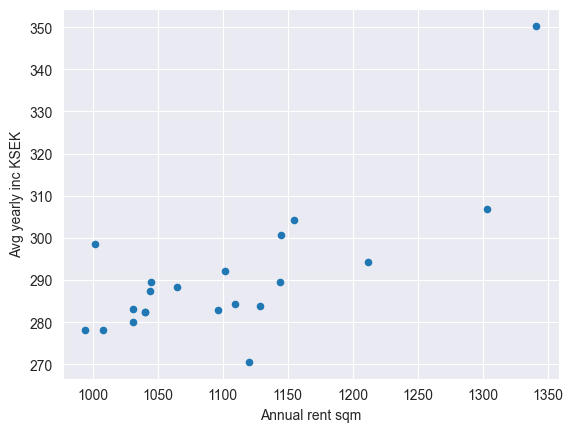

In [522]:
income_vs_rent_data.plot.scatter(x='Annual rent sqm', y='Avg yearly inc KSEK')

## Implement clustering
As mentioned in the introduction section you will create your K-means function from
scratch.
- Initialize the centroids with a starting number of clusters you consider correct, the centroids can be selected as a random point among your sample.
- Find which point belongs to which cluster by finding the closer centroid to every point
(Euclidean distance).
- Calculate the mean point among each cluster to obtain the new centroid
- Repeat this process N (around 10)  number of iterations until the mean of the new
cluster does not change from the previous iteration.
- Create once again a cluster plot with colors assigned for each cluster. For information on
how to do this plot, check: https://pythonguides.com/matplotlib-scatter-plot-color/

First let's implement a function calculating the euclidean distance

In [523]:
def eucledian_distance(point, array_of_points):
    return np.sqrt(np.sum((point - array_of_points)**2, axis=1))

Now we can implement the k-means algorithm:

In [524]:
from random import randint


def my_kmeans(data, number_of_clusters, distance_measure, max_iterations=10):
    def calculate_closest_points_to_centroid(centroids):
        closest_points_to_centroid = [[] for _ in range(number_of_clusters)]
        for data_point in data:
            closest_centroid_index = np.argmin(
                distance_measure(data_point, centroids)
            )
            closest_points_to_centroid[closest_centroid_index].append(
                data_point
            )
        return closest_points_to_centroid

    def calculate_new_centroids(centroids, closest_points_to_centroid):
        new_centroids = [[] for _ in range(number_of_clusters)]
        for i, cluster_points in enumerate(closest_points_to_centroid):
            if not cluster_points:
                new_centroids[i] = centroids[i]
            else:
                new_centroids[i] = np.mean(cluster_points, axis=0)
        return new_centroids

    random_index = randint(0, data.shape[0]-1)
    centroids = [data[random_index] for _ in range(number_of_clusters)]

    for iteration in range(0, max_iterations):
        closest_points_to_centroid = calculate_closest_points_to_centroid(
            centroids
        )
        new_centroids = calculate_new_centroids(
            centroids, closest_points_to_centroid
        )
        converged = np.all(np.equal(centroids, new_centroids))
        if converged:
            break
        else:
            centroids = new_centroids

    # Cluster assignment
    all_centroids = []
    all_centroid_ixs = []
    for data_point in data:
        centroid_idx = np.argmin(distance_measure(data_point, centroids))
        all_centroids.append(centroids[centroid_idx])
        all_centroid_ixs.append(centroid_idx)

    return all_centroids, all_centroid_ixs

We only need the rent and income columns for the clustering.

In [525]:
income_vs_rent_data_for_clustering = income_vs_rent_data[
    ['Annual rent sqm', 'Avg yearly inc KSEK']
].values.astype(np.float32)

Now we can use our function to perform the k-means clustering. Let's use 3 clusters to begin with.

In [526]:
centroids, assigned_clusters = my_kmeans(
    income_vs_rent_data_for_clustering,
    number_of_clusters=3,
    distance_measure=eucledian_distance,
)
income_vs_rent_data['cluster'] = assigned_clusters

To see if the results are reasonable, let's do a scatter plot again, but this time color the points according to the cluster index.

Text(0, 0.5, 'Avg yearly inc KSEK')

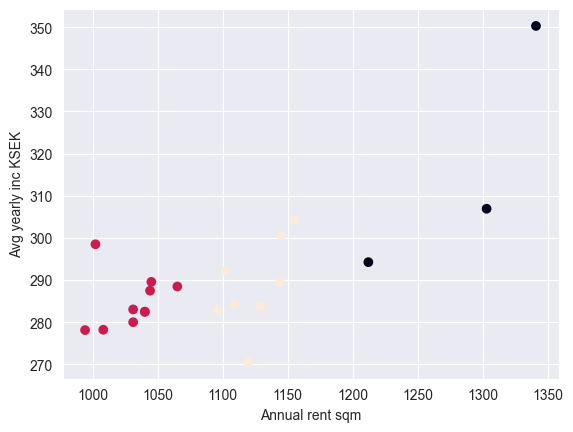

In [527]:
plt.scatter(
    x=income_vs_rent_data['Annual rent sqm'],
    y=income_vs_rent_data['Avg yearly inc KSEK'],
    c=income_vs_rent_data['cluster'],
)
plt.xlabel('Annual rent sqm')
plt.ylabel('Avg yearly inc KSEK')

We can see that the data points have been clustered mostly according to the annual rent per square meter, the average yearly income was largely ieft ignored by the k-means algorithm.

# Task 4 - Grid search for hyperparameter optimization
## Silhouette score
- In order to perform the hyperparameter optimization for the number of clusters you will
  use the silhouette score, for this score create a function that finds the silhouette coefficient for
  each of the clusters and plot them.
  For more information on the silhouette score and how it can be obtained with Scikit-
  learn, check page 247 of the ML book.

  The silhouette coefficient for each point (i) can be obtained as follows:
  $$S_i = \frac{b_i - a_i}{\textrm{max}[a_i, b_i]}$$
  Where:
    - $S_i$ is the silhouette coefficient of the data point i.
    - $a_i$ is the average distance between $i$ and all the other data points in the cluster
    to which $i$ belongs.
    - $b_i$ is the average distance from $i$ to all the points to the closest cluster to which
    $i$ does not belong.

- Create a function $a_i$ that calculates the average intra-cluster distance from any point $i$.
- Create a function that calculates the average inter-cluster distance to the closets cluster
  from datapoint $i$.
- Create a main function that iterates over all points in the dataset and calculates $S_i$
- Finally, obtain the average $S_i$ for all points for each cluster value to get the cluster’s
silhouette coefficient.
- Graph the cluster’s silhouette coefficient such as the example in the book does to find
the optimal number of clusters.

In [528]:
def mean_distance(point, points_in_cluster):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        return np.mean(eucledian_distance(point, points_in_cluster))

def mean_intra_cluster_distance(
    all_points: pd.DataFrame, all_clusters: list, index_point: int
):
    cluster = all_clusters[index_point]
    current_point = all_points[index_point]
    not_current_point = False
    for dim in range(all_points.shape[-1]):
        not_current_point |= (all_points[:, dim] != current_point[dim])
    return mean_distance(
        current_point,
        all_points[(all_clusters == cluster) & not_current_point],
    )

def mean_inter_cluster_distance(
    all_points: pd.DataFrame, all_clusters: list, index_point: int
):
    cluster = all_clusters[index_point]
    all_mean_distances = [
        mean_distance(
            all_points[index_point], all_points[all_clusters == other_cluster]
        )
        for other_cluster in all_clusters if other_cluster != cluster
    ]
    return min(all_mean_distances)

def get_silhouette_coefficients(all_points: pd.DataFrame, all_clusters: list):
    n = all_points.shape[0]
    a = np.array([
        mean_intra_cluster_distance(all_points, all_clusters, i)
        for i in range(n)
    ])
    b = np.array(
        [mean_inter_cluster_distance(all_points, all_clusters, i)
         for i in range(n)]
    )
    s = (b - a) / np.maximum(a, b)
    s[np.isnan(s)] = 0
    return s


Now we have everything to calculate the silhouette coefficients

In [529]:
all_the_assigned_clusters = []
coefficients = []
for n_clusters in range(2, 8):
    centroids, assigned_clusters = my_kmeans(
        income_vs_rent_data_for_clustering,
        n_clusters,
        distance_measure=eucledian_distance,
    )
    silhouette_coefficients = get_silhouette_coefficients(
        income_vs_rent_data_for_clustering, assigned_clusters
    )
    coefficients.append(silhouette_coefficients)
    print(f"Silhouette score for {n_clusters} clusters: "
          f"{silhouette_coefficients.mean()}")
    all_the_assigned_clusters.append(assigned_clusters)

Silhouette score for 2 clusters: 0.5265740156173706
Silhouette score for 3 clusters: 0.6291077733039856
Silhouette score for 4 clusters: 0.5711745023727417
Silhouette score for 5 clusters: 0.44884371757507324
Silhouette score for 6 clusters: 0.43039506673812866
Silhouette score for 7 clusters: 0.35341715812683105


Validate that the silhouette coefficients are correct with scikit-learn's methods on a simple dataset:

In [530]:
# TESTING
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples


X = pd.DataFrame([[0, 0], [0, 1], [2, 2], [2, 3], [2, 4], [7, 7]])
for n in range(2, 5):
    kmeans = KMeans(n_clusters=n).fit(X)
    sklearn_silhouette_coefficients = silhouette_samples(X, kmeans.labels_)
    sklearn_silhouette_score = silhouette_score(X, kmeans.labels_)
    my_silhouette_coefficients = get_silhouette_coefficients(X.values, list(kmeans.labels_))
    assert (my_silhouette_coefficients == sklearn_silhouette_coefficients).all()
    assert my_silhouette_coefficients.mean() == sklearn_silhouette_score


To get more insights into which parameter might be best, create the whole silhouette plot instead of relying on a single scalar metric.

In [531]:
import matplotlib.cm as cm


def silhouette_plot(n_clusters, sample_silhouette_values, cluster_labels):
    #
    # Source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    #
    silhouette_average = np.mean(sample_silhouette_values)

    figure, axis1 = plt.subplots(1, 1)
    figure.set_size_inches(10, 7)
    axis1.set_xlim([-0.1, 1])
    # The (n_clusters + 1) * 10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    axis1.set_ylim([0, len(sample_silhouette_values) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        cluster_silhouette_values_i = sample_silhouette_values[
            cluster_labels == i
        ]
        cluster_silhouette_values_i.sort()
        size_cluster_i = cluster_silhouette_values_i.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axis1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_silhouette_values_i,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        axis1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axis1.set_title('The silhouette plot for the various clusters.')
    axis1.set_xlabel('The silhouette coefficient values')
    axis1.set_ylabel('Cluster label')
    # The vertical line for average silhouette score of all the values
    axis1.axvline(x=silhouette_average, color='red', linestyle='--')
    axis1.set_yticks([])  # Clear the yaxis labels / ticks
    axis1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        f'Silhouette analysis n_clusters = {n_clusters}',
        fontsize=14,
        fontweight='bold',
    )

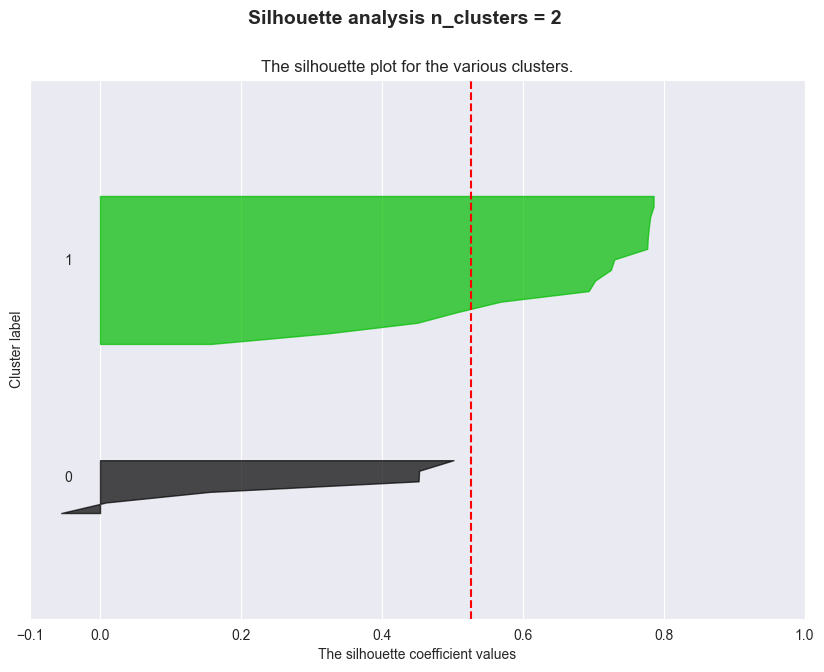

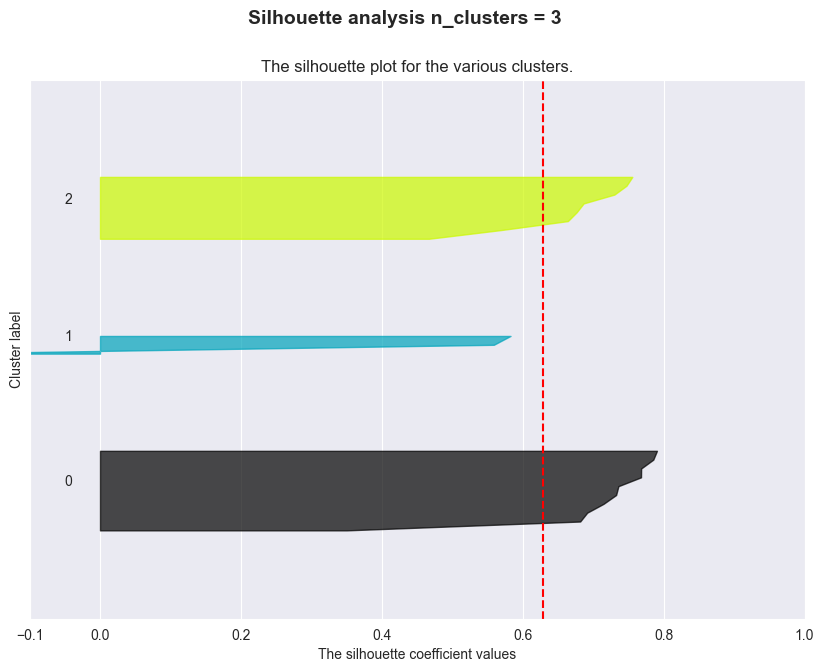

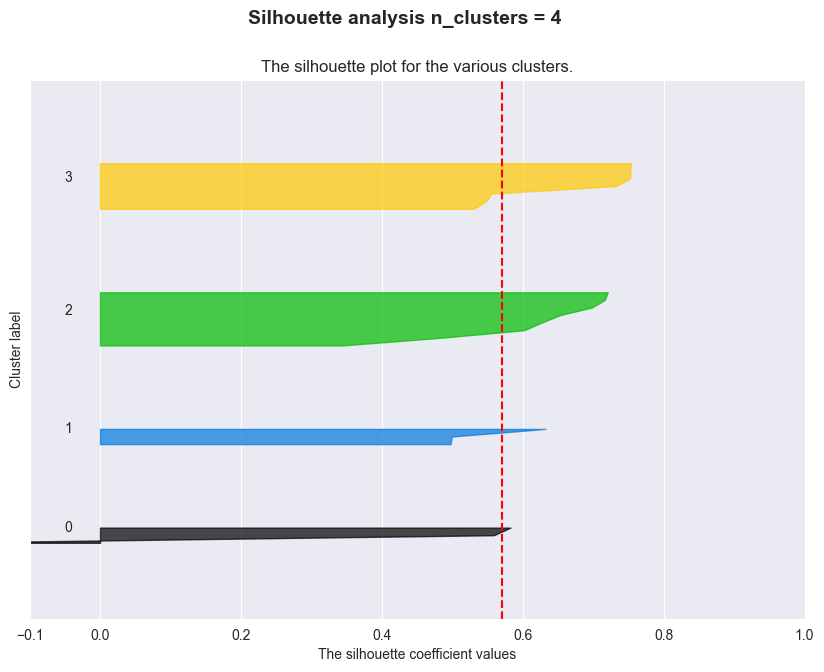

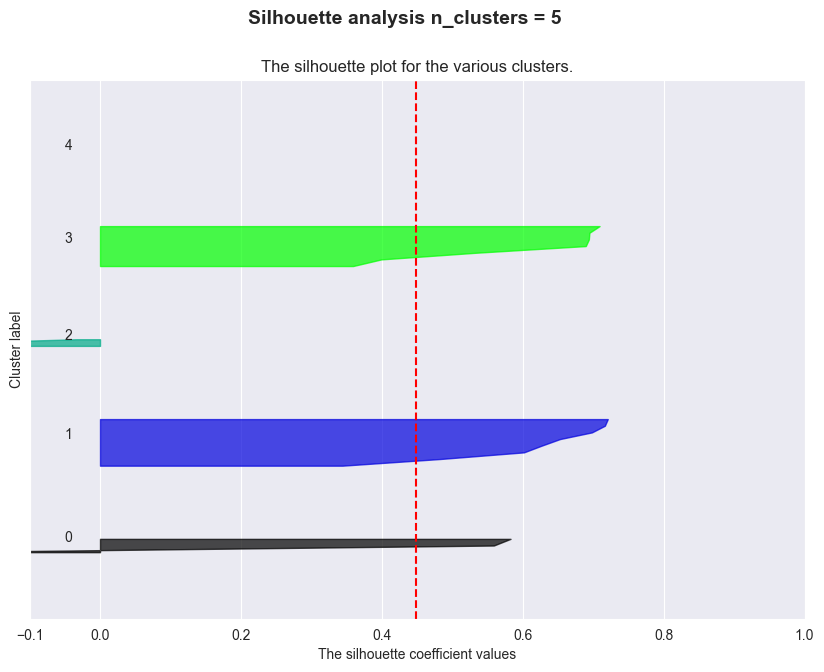

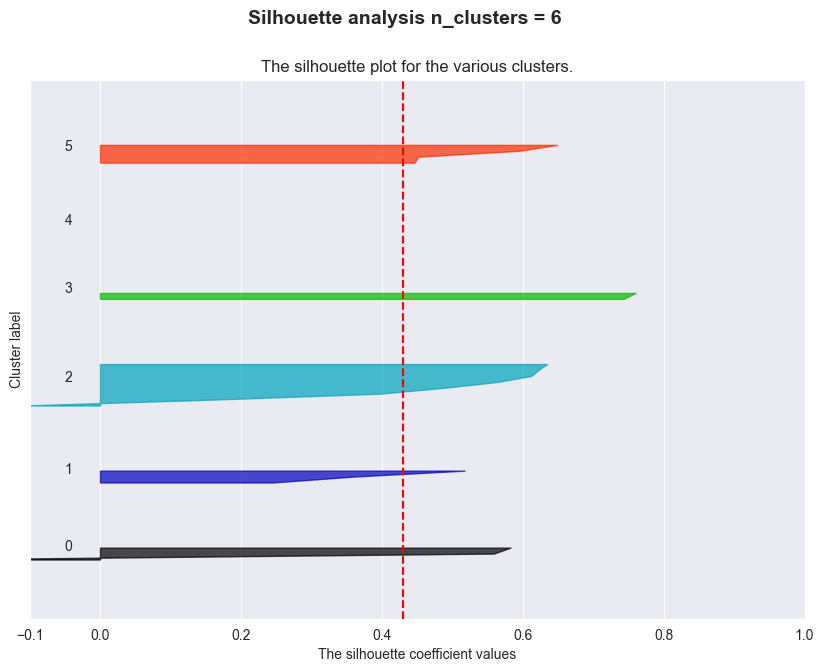

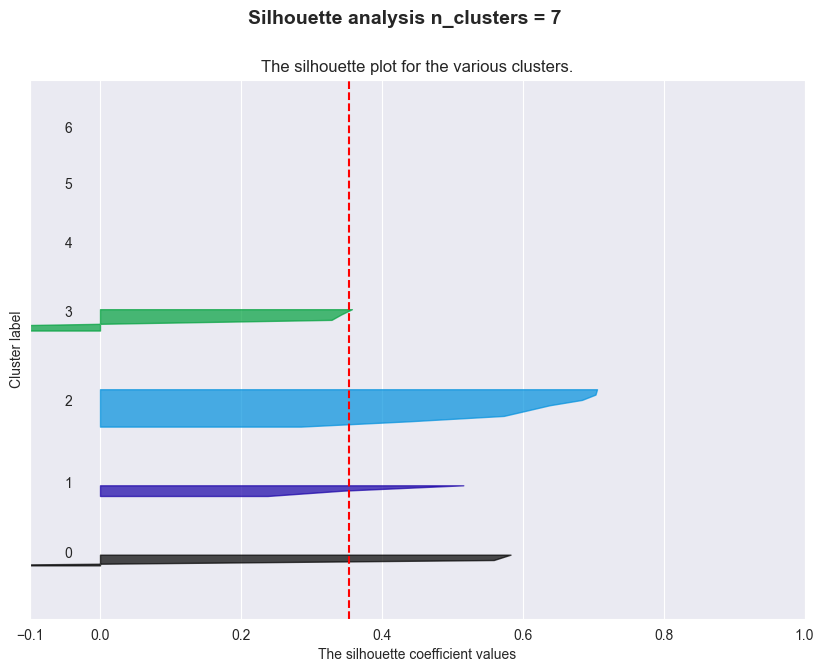

In [532]:
for n_clusters in range(2, 8):
    silhouette_plot(
        n_clusters,
        coefficients[n_clusters - 2],
        np.array(all_the_assigned_clusters[n_clusters - 2])
    )

Based on the silhouette plots and scores above, it would appear that 3-4 clusters look pretty good with wide plots (close to 1 in coefficient), and mostly over the mean line.

While $n=3$ had the highest scalar silhouette score, there is a slight cluster overlap (i.e. some negative silhouette coefficients) and difference in the size of the clusters in the sample.
For $n=4$ the silhouette coefficients are all positive, which means the clusters are more clearly separated, the aggregated score is just slightly lower (two clusters seem a bit close) and the cluster sizes are similar. Let's go with 4.

In [533]:
n_clusters = 4
centroids, assigned_clusters = my_kmeans(
    income_vs_rent_data_for_clustering,
    n_clusters,
    distance_measure=eucledian_distance
)

Add the assigned cluster to the data frame

In [534]:
income_vs_rent_data['cluster'] = assigned_clusters

## Scatter plot
Llet's create a scatter plot again but this time color the points with the cluster index

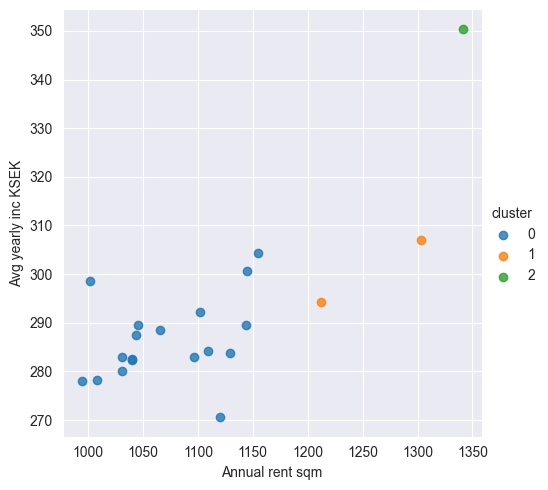

In [535]:
sns.lmplot(
    x='Annual rent sqm',
    y='Avg yearly inc KSEK',
    data=income_vs_rent_data,
    hue='cluster',
    fit_reg=False,
)


## Evaluate how the created model predicts new values
For this task we will assume we have 3 unnamed regions with the following annual rent
and average salary:

$$[1010, 320.12], [1258, 320], [980, 292.4]$$

- Find which cluster these data points belong to and plot them in the graph.
- Based on the cluster graph do you think your model successfully predicted the cluster
  for these values?

In [536]:
points_to_cluster = np.array(
    [[1010, 320.12], [1250, 320], [980, 292.4]]
)


def find_closest_centroid(
    point, centroids, distance_measure=eucledian_distance
):
    centroid_index = np.argmin(distance_measure(point, centroids))
    return centroids[centroid_index]


def predict_clusters(points_to_cluster, centroids, assigned_clusters):
    predicted_centroids = [
        find_closest_centroid(
            point, list({tuple(centroid) for centroid in centroids})
        ) for point in points_to_cluster
    ]
    centroids_with_tuples = [tuple(c) for c in centroids]
    predicted_clusters = [
        assigned_clusters[centroids_with_tuples.index(pc)]
        for pc in predicted_centroids
    ]
    return predicted_clusters


predicted_clusters = predict_clusters(
    points_to_cluster, centroids, assigned_clusters
)

Let's create another dataframe out of the predicted data points

In [537]:
points_to_cluster_df = pd.DataFrame(
    points_to_cluster, columns=['Annual rent sqm', 'Avg yearly inc KSEK']
)
points_to_cluster_df['cluster'] = predicted_clusters


Now let's put the newly predicted points on the scatter plot, marked by Xes

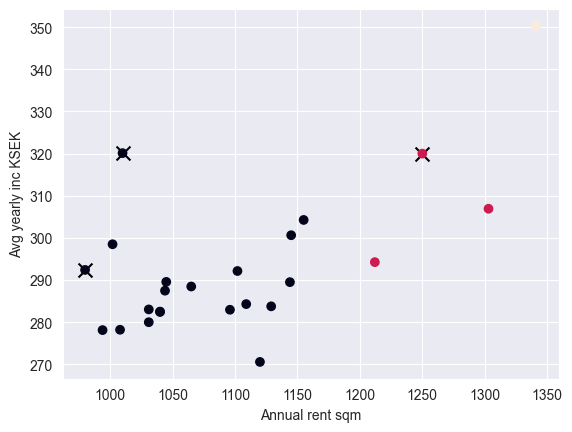

In [538]:
plt.scatter(
    x=points_to_cluster_df['Annual rent sqm'],
    y=points_to_cluster_df['Avg yearly inc KSEK'],
    c='black', marker='x', s=100,
)
plt.scatter(
    x=pd.concat([
        income_vs_rent_data['Annual rent sqm'],
        points_to_cluster_df['Annual rent sqm']
    ]),
    y=pd.concat([
        income_vs_rent_data['Avg yearly inc KSEK'],
        points_to_cluster_df['Avg yearly inc KSEK']
    ]),
    c=pd.concat([
        income_vs_rent_data['cluster'], points_to_cluster_df['cluster']
    ]),
)
plt.xlabel('Annual rent sqm')
plt.ylabel('Avg yearly inc KSEK')
plt.show()

It looks like the three data points have been clustered properly.

## Optional advanced task - create N-dimensional grid search optimizer

The grid search function implemented above can handle an arbitrary number of hyperparameters. It does so by creating a cartesian product of all parameter values.